In [169]:
import numpy as np
from typing import List, Union
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Data

In [170]:
X, Y = load_iris(return_X_y=True)
X.shape, Y.shape

((150, 4), (150,))

In [171]:
labels = np.eye(3)[Y]
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

## Model

In [173]:
class Module:
    def forward(self, X):
        raise NotImplementedError
        
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, X, grad):
        raise NotImplementedError

class Sigmoid(Module):
    def forward(self, X):
        return 1/(1 + np.exp(-X))
    
    def backward(self, X, grad):
        z = self.forward(X)
        return grad*z*(1 - z)
    
class Linear(Module):
    def forward(self, X):
        return X
    def backward(self, X, grad):
        return grad
    
class ReLU(Module):
    def forward(self, X):
        return np.maximum(X, 0)
    def backward(self, X, grad): 
        grad_t = np.array(grad, copy = True)
        grad_t[X <= 0] = 0
        return grad_t
        
    
class TanH(Module):
    def forward(self, X):
        return np.tanh(X)
    
    def backward(self, X, grad):
        z = self.forward(X)
        return grad* (1 - z**2)
        
def softmax(x, axis=0):
    s = np.exp(x - x.max(axis=axis))
    return s/s.sum(axis=axis)        

In [174]:
#layer_implementation
class Layer(Module):
    def __init__(self, dim_in : int, dim_out : int, act : Module):
        self.W = np.random.randn(dim_out, dim_in)
        self.B = np.zeros(shape=(dim_out,1), dtype=float)
        self.act = act
        
    def __str__(self):
        return f'Layer(W={self.W}, B={self.B})'
    
    def __repr__(self):
        return self.__str__()
    
    def forward(self, X):
        o = self.act(self.W@X + self.B)
        return o
    
    def backward(self, X : np.array, grad: np.array, lr : float):
        h = self.forward(X)
        m = h.shape[1]
        grad = self.act.backward(h, grad)
#         print('grad norm:' ,np.linalg.norm(grad))
        grad_W = (1/(2*m)) * grad @ X.T
        grad_B = (1/(2*m)) * np.sum(grad, axis=1, keepdims=True)
        grad = self.W.T @ grad
#         print('gradW:', grad_W.shape, 'gradB:', grad_B.shape, 'grad act:', grad.shape)
        
        self.W -= lr*grad_W
        self.B -= lr*grad_B
        return grad
    
    
    
class Model(Module):
    def __init__(self, dims : List[int], acts : List[Module]):
        self.layers = []
        for i, dim in enumerate(dims[:-1]):
            print(enumerate(dims[:-1]))
            self.layers += [Layer(dim, dims[i+1], acts[i])]
            
    def __repr__(self):
        return "Model(\n  " + '\n  '.join(map(str, self.layers)) + '\n)'
        
    def forward(self, X : np.array):
        h = self.layers[0](X)
        for layer in self.layers[1:]:
            h = layer(h)
        return h
    
    def calc_metrics(self, y, preds):
        probs = softmax(preds)
        loss = np.mean(-np.sum(y.T*np.log(probs+1e-9), axis=0))
        acc = np.mean(np.argmax(probs, axis=0) == np.argmax(y, axis=1))
        return loss, acc
    
    def fit(self, X: np.array, y : np.array, lr: Union[float, List[float]]):
        if isinstance(lr, float):
            lr = [lr]*len(self.layers)
        else:
            assert len(lr) == len(self.layers), "Please specify LR for each layer."
            
        vectors = [X.T]
        for layer in self.layers:
            vectors += [layer(vectors[-1])]
            
        probs = softmax(vectors[-1])
        loss, acc = self.calc_metrics(y, vectors[-1])
        
        grad = probs - y.T
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(vectors[i], grad, lr[i])
        
        return loss, acc

In [176]:
model = Model(dims=[4,5,2,3], acts=[ReLU(), Sigmoid(), TanH()])
model

Model(
  Layer(W=[[ 1.03301967  0.42349953 -0.24075644  2.17641654]
 [ 0.09501571 -0.19458794  0.65731439  0.77943691]
 [ 0.49588207  0.00901067  0.93281448 -0.30103897]
 [ 0.68989587 -0.58363041 -2.18826131 -0.77546003]
 [-0.89170873  0.43279373 -0.36472926  0.20803958]], B=[[0.]
 [0.]
 [0.]
 [0.]
 [0.]])
  Layer(W=[[-1.01577258  0.10322182  1.19323945  0.39501023 -0.23940333]
 [ 0.50008033 -1.8828114   0.24473965 -0.95236453  0.28602004]], B=[[0.]
 [0.]])
  Layer(W=[[-0.40564402  1.29703794]
 [-1.94373679  1.55002248]
 [ 0.88647286  0.71715341]], B=[[0.]
 [0.]
 [0.]])
)

In [177]:
train_losses = []
test_losses = []

train_accs = []
test_accs = []

for epoch in tqdm(range(2500)):
    loss, acc = model.fit(X_train, y_train, lr=0.05)
    train_losses += [loss]
    train_accs += [acc]
    
    preds = model(X_test.T)
    loss, acc = model.calc_metrics(y_test, preds)
    test_losses += [loss]
    test_accs += [acc]

  0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-173-6fcbcb3c4c23>:13: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-X))


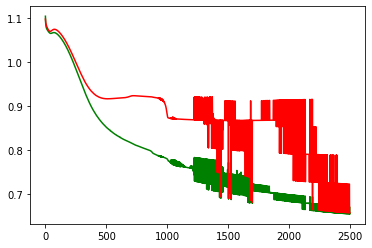

In [178]:
plt.plot(train_losses,color='g')
plt.plot(test_losses,color='r')

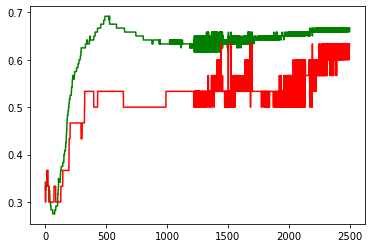

In [179]:
plt.plot(train_accs,color='g')
plt.plot(test_accs,color='r')
plt.show()

In [180]:
test_accs[-1]

0.6333333333333333